In [1]:
#this file set action mask
from IPython import get_ipython
import random
import matplotlib.pyplot as plt
from IPython import display
from tqdm.notebook import tqdm
from typing import Tuple, List
import itertools as it
import numpy as np
import pandas as pd
import plotly.express as px
import statistics as s
import os
import csv
from collections import deque
from itertools import product
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import inspect
import warnings
warnings.filterwarnings('ignore')
import dyna_env_acdy
from dyna_env_acdy import TaskEnv_actionD
from agent_dynaaction import RandomMaskedAgent, MaskedQLearningAgent,MaskedDQNAgent,PPOAgent,ValueIterationAgent,MetaMaskedDQNAgent

In [2]:
def save_to_csv(data, filename):
    os.makedirs("dynaaction", exist_ok=True)
    path = os.path.join("dynaaction", filename)
    with open(path, mode="w", newline="") as file:
        writer = csv.writer(file)
        if isinstance(data, dict):
            writer.writerow(["State", "Action"])
            for k, v in data.items():
                writer.writerow([k, v])
        elif isinstance(data, list):
            writer.writerow(data)
        else:
            raise ValueError("Unsupported data format for saving.")

In [3]:

def compare_agents_plot(reward_lists, labels,type):
    """
    reward_lists: list of 1D lists or arrays of episodic rewards for each agent
    labels: list of labels for each agent (e.g., ["Random", "Q-Learning", "Value Iteration", "Policy Iteration"])
    """
    def smooth(arr):
        arr = np.array(arr)
        return pd.Series(arr).rolling(window=40).mean()
    
    x = np.arange(1, 2101)  # 100 segments
    colors = cm.plasma(np.linspace(0, 0.9, len(reward_lists)))
    
    # 创建两个子图
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))  # 总宽度24以容纳两个12宽的图
    
        # 第二个图：不使用smooth
    for rewards, label, color in zip(reward_lists, labels, colors):
        y = rewards
        ax1.plot(x, y, label=label, color=color, alpha=0.7)  # 添加透明度使原始数据更易读
    
    ax1.axvline(x=700, color='red', linestyle='--', label='disable 2 actions')
    ax1.axvline(x=1400, color='red', linestyle='--', label='add 2 actions')
    if type == 'reward':
        ax1.set_title("Compare different agent performance by reward (Raw Data)")
        ax1.set_xlabel("Episodes")
        ax1.set_ylabel("Episodic Reward")
    elif type =='length':
        ax1.set_title("Compare different agent performance by step length (Raw Data)")
        ax1.set_xlabel("Episodes")
        ax1.set_ylabel("Episodic step length")
    ax1.legend()
    ax1.grid(True)
    
    # 第一个图：使用smooth
    for rewards, label, color in zip(reward_lists, labels, colors):
        y = smooth(rewards)
        ax2.plot(x, y, label=label, color=color)
    
    ax2.axvline(x=700, color='red', linestyle='--', label='disable 2 actions')
    ax2.axvline(x=1400, color='red', linestyle='--', label='add 2 actions')
    if type == 'reward':
        ax2.set_title("Compare different agent performance by reward (Smoothed - 30 window size)")
        ax2.set_xlabel("Episodes")
        ax2.set_ylabel("Average Episodic Reward")
    if type =='length':
        ax2.set_title("Compare different agent performance by step length (Smoothed - 30 window size)")
        ax2.set_xlabel("Episodes")
        ax2.set_ylabel("Average Episodic Step Length")

    ax2.legend()
    ax2.grid(True)
    
    
    plt.tight_layout()
    plt.show()

In [4]:
def run_agent_apply_drift(agent_type,apply_drift=True,add_actions=0, change_at_states=['pp'], drift_dis_type='random',intensity = 0.7,drift_type='sudden'):
    #initial agent
    env = TaskEnv_actionD()
    state_dim = len(env.states) 
    action_dim = len(env.motions)  
    state_to_index = {state: idx for idx, state in enumerate(env.states)}
    agent = None
    max_action_dim = 20
    
    match agent_type:
        case 'Q':
            agent = MaskedQLearningAgent(env)
        case 'DQN':
            agent = MaskedDQNAgent(env, state_dim, lr=1e-3, epsilon_decay=0.998)
        case 'PPO':
            agent = PPOAgent(state_dim, max_action_dim)
        case 'Opt':
            agent = ValueIterationAgent(env)
            agent.value_iteration()
            for state, action in agent.policy.items():
                print(f"In state {state}, take action: {action}")
        case 'R':
            agent = RandomMaskedAgent(env)
        case 'MetaDQN':
            agent = MetaMaskedDQNAgent(env)
  
    
    episode_rewards = []
    episode_lengths = []
    episodic_trojactory = []
    information = {}

    total_episodes = 2100
    drift_episodes=[700,1400]
    update_interval=10  #for PPO
    episode_meta_losses = []

    suffix = f"changestate{change_at_states}_{agent_type}"

    for episode in range(total_episodes):
        steps = 0
        # 应用drift
        if apply_drift:             
            env.set_flag()  # Enable drift
            
            # Example: Remove 2 actions by disabling them
            if episode == drift_episodes[0]:
                env.drift(add_actions=-2, 
                        drift_type='sudden',
                        disable_actions=['client afgeleid', 'naar andere kamer/ruimte gestuurd'])
                
                #print("Action info after drift:")
                #print(env.get_action_info())
                if agent =='Opt':
                    agent.value_iteration()
                   # print(f"In state {state}, take action: {action}")

            if episode == drift_episodes[1]:
                env.drift(add_actions=2, drift_type='sudden')
            # disable_actions=['client afgeleid', 'naar andere kamer/ruimte gestuurd'])
                #print("Action info after drift:")
                #print(env.get_action_info())
                if agent =='Opt':
                    agent.value_iteration()
                   # print(f"In state {state}, take action: {action}")

        """    
                suffix = f"{agent_type}_{apply_drift}_{change_at_states}_{drift_dis_type}"
                save_to_csv(agent.policy, f"{suffix}_optpolicy.csv")
        """
        if agent == 'MetaDQN':
                        # 重置目标网络以加速适应新环境
            agent.target_net.load_state_dict(agent.policy_net.state_dict())

        state = env.reset()
        episode_reward = 0
        done = False
        
        while not done:
            action_mask = env.get_action_mask()
        
            if agent_type == 'Q':
               # print(agent)
                action = agent.select_action(state,action_mask)

            elif agent_type in['R']:
                action = agent.select_action()
            
            elif agent_type == 'Opt':
                action = agent.select_action(state)

            elif agent_type =='DQN':
                action = agent.act(state, action_mask)

            elif agent_type =='PPO':
                action, log_prob, value = agent.select_action(state, action_mask)

            elif agent_type =='MetaDQN':
                use_meta_weights = (episode in drift_episodes)  # 在漂移发生时使用元学习权重
                action = agent.act(state, action_mask, fast_adapt=use_meta_weights)
            
                #action = agent.act(state)
            
            
            next_state, reward, done, info = env.step(action)
            
            if info != []:
                key = ''.join(str(x) for x in info)
                if key not in information:
                    information[key] = 1
                else:
                    information[key] += 1
            if agent_type == 'Q':
                #print(agentt
                if not done:
                    next_action_mask = env.get_action_mask()
                else:
                    next_action_mask = [True] * len(env.motions)  # Doesn't matter for terminal state
                agent.update(state, action, reward, next_state, next_action_mask, done)


            elif agent_type== 'DQN':
                agent.remember(state, action, reward, next_state, done, action_mask)
                #agent.train(batch_size=1, state_to_index=state_to_index)
                loss = agent.replay()

                
            elif agent_type =='PPO':
                agent.store_transition(state, action, reward, log_prob, value, done, action_mask)


            elif agent_type =='MetaDQN':
            # 存储经验
                agent.remember(state, action, reward, next_state, done,action_mask)
                
                # 常规经验回放
                loss = agent.replay()
                
                # 元学习训练（在漂移发生后加强元学习）
                if (episode in drift_episodes) or (episode % 10 == 0):  # 漂移时或定期执行
                    meta_loss = agent.meta_update()
                    if meta_loss is not None:
                        episode_meta_losses.append(meta_loss)
                  
            state = next_state
            episode_reward += reward
            steps +=1
        if agent_type=='PPO':
            if (episode + 1) % update_interval == 0:
                agent.update()
                agent.clear_memory()
            
        episodic_trojactory.append(info)
        episode_lengths.append(steps)
        episode_rewards.append(episode_reward)
    
    return episode_rewards, episode_lengths,information,episodic_trojactory



def run_agent_avg(agent_type, apply_drift=True, add_actions=0, 
                  change_at_states=['pp','po','va','sib'], 
                  drift_dis_type='random', intensity=0.7, drift_type='sudden'):
    
    num_runs = 100
    all_rewards = []
    all_lengths = []
    info_first_run = None

    for run in range(num_runs):
        rewards, lengths, info, trojactory= run_agent_apply_drift(
            agent_type=agent_type,
            apply_drift=apply_drift,
            add_actions=add_actions,
            change_at_states=change_at_states,
            drift_dis_type=drift_dis_type,
            intensity=intensity,
            drift_type=drift_type
        )
        all_rewards.append(rewards)
        all_lengths.append(lengths)
        if run == 0:
            info_first_run = info
            trojactory_first_run = trojactory

    # Convert to numpy arrays for averaging
    all_rewards = np.array(all_rewards)
    all_lengths = np.array(all_lengths)

    avg_rewards = np.mean(all_rewards, axis=0).tolist()
    avg_lengths = np.mean(all_lengths, axis=0).tolist()

    sd_rewards = np.std(all_rewards, axis=0).tolist()
    sd_lengths = np.std(all_lengths, axis=0).tolist()

    return avg_rewards, avg_lengths, sd_rewards, sd_lengths #info_first_run,trojactory_first_run

In [5]:
list1 = [[1,2],[3,4]]
list1[0][1]
for i in range(0,1):
    print(i)

0


In [6]:
from typing import List
import numpy as np

def reward_to_score(r: float, r_opt: float, r_min: float) -> float:
    """归一化 reward 为正向 score（越大越好）"""
    return (r - r_min) / (r_opt - r_min)

def check_recovery_negative_rewards(
    opt_pre_drift: List[float],
    agent_pre_drift: List[float],
    #random_pre_drift: List[float],
    opt_post_drift: List[float],
    agent_post_drift: List[float],
    window_size: int = 50,
    consecutive_required: int = 200
):
    # Step 1: 计算 pre-drift 和 post-drift 的平均 reward
    r_opt_pre = np.mean(opt_pre_drift)
    r_agent_pre = np.mean(agent_pre_drift)

    for i in range(0,2):

        r_opt_post = np.mean(opt_post_drift[i])

        # Step 2: 找到合理的 reward 下界，用于归一化
        r_min = min(min(agent_pre_drift), min(opt_pre_drift),
                    min(agent_post_drift[i][:-100]), min(opt_post_drift[i])) - 1 # 避免除以0

        #print("the value compute stander",r_agent_pre, r_opt_pre, r_min)
        # Step 3: 计算 pre-drift agent 的标准表现分数 alpha
        #score_opt_pre = reward_to_score(r_opt_pre, r_opt_pre, r_min)  # 始终为1
        score_agent_pre = reward_to_score(r_agent_pre, r_opt_pre, r_min)
        alpha = score_agent_pre
       # print('the alpha value:', alpha)
        # Step 4: 设定恢复标准（90% of pre-drift performance）
        recovery_threshold = 0.95 * alpha

        # Step 5: 对 post-drift agent 的 reward 做 rolling window
        recovery_streak = 0
        windows_rolled = 0
        recovered = False

        for j in range(len(agent_post_drift[i]) - window_size + 1):
            window = agent_post_drift[i][j : j + window_size]
            window_mean = np.mean(window)
            window_score = reward_to_score(window_mean, r_opt_post, r_min)
            windows_rolled += 1

            if window_score >= recovery_threshold:
                recovery_streak += 1
                if recovery_streak == consecutive_required:
                    recovered = True
                    break
            else:
                recovery_streak = 0

        
        print(f"Agent pre-drift average reward: {r_agent_pre:.3f}")
        print(f"Optimal pre-drift average reward: {r_opt_pre:.3f}")
        print(f"Recovery standard (90% of relative performance): {recovery_threshold:.3f}")
        print(f"Recovered: {recovered}")
        if recovered:
            print(f"Recovery achieved in {windows_rolled} windows")
        else:
            print(f"Recovery not achieved in {windows_rolled} windows")
        print("========== RECOVERY EVALUATION ==========")
        
    """
    return {
        "standard": recovery_threshold,
        "recovered": recovered,
        "recovery_steps": windows_rolled if recovered else None
    }
"""


In [7]:
def test_all_agents():
    agent_types = ['R', 'Q', 'DQN', 'PPO','MetaDQN','Opt']
    compare_rewards = []
    compare_lengths = []
    std_rewds = []
    std_lens = []

    #for compute if the agent recover
    rew_before_drift = [] #per agent
    rewlist_drift = [] #element 也是list 第一个是disable 两个 action的，后一个是加入两个action的
    fullrewlist_drift=[]

    for agent_type in agent_types:
        print(f"Running agent_type={agent_type}")
        rewards, lengths, std_rew,std_len = run_agent_avg(agent_type=agent_type, apply_drift=True,drift_dis_type='inverse',drift_type='sudden')
        compare_rewards.append(rewards)
        compare_lengths.append(lengths)
        std_rewds.append(std_rew)
        std_lens.append(std_len)


        rew_before_drift.append(rewards[600:700])
        rewlist_drift.append([rewards[1300:1400],rewards[:-100]])
        fullrewlist_drift.append([rewards[700:1400],rewards[1400:]])

        suffix = f"{agent_type}_dynaaction"
        
        """
       # suffix = f"{agent_type}_[pp]_None"
        #save_to_csv(opt_agent.policy, f"{suffix}_optpolicy.csv")
        save_to_csv(rewards, f"{suffix}_rewards.csv")
        save_to_csv(lengths, f"{suffix}_lengths.csv")
       # save_to_csv([[k, v] for k, v in info.items()], f"{suffix}_info.csv")
          
        #df = pd.DataFrame(trojactory)
        #df.to_csv(f"./diffagent_res_gradual_random/{suffix}_trojactory.csv", index=True, header=True)
  
    df = pd.DataFrame([std_rewds, std_lens])
    df.index = ['std_rews', 'std_lens']
    df.to_csv(f"./stdRewLen/{suffix}.csv", index=True, header=True)"""

    compare_agents_plot(compare_rewards, agent_types,'reward')
    compare_agents_plot(compare_lengths, agent_types,'length')

    for i in range(1,6):
        print('analysis for agent type:',agent_types[i])
        check_recovery_negative_rewards(
        rew_before_drift[-1],
        rew_before_drift[i],
        rewlist_drift[-1],
        fullrewlist_drift[i])

Running agent_type=R
Disabled actions: ['client afgeleid', 'naar andere kamer/ruimte gestuurd']
Added 2 new actions: ['a0', 'a1']
Disabled actions: ['client afgeleid', 'naar andere kamer/ruimte gestuurd']
Added 2 new actions: ['a0', 'a1']
Disabled actions: ['client afgeleid', 'naar andere kamer/ruimte gestuurd']
Added 2 new actions: ['a0', 'a1']
Disabled actions: ['client afgeleid', 'naar andere kamer/ruimte gestuurd']
Added 2 new actions: ['a0', 'a1']
Disabled actions: ['client afgeleid', 'naar andere kamer/ruimte gestuurd']
Added 2 new actions: ['a0', 'a1']
Disabled actions: ['client afgeleid', 'naar andere kamer/ruimte gestuurd']
Added 2 new actions: ['a0', 'a1']
Disabled actions: ['client afgeleid', 'naar andere kamer/ruimte gestuurd']
Added 2 new actions: ['a0', 'a1']
Disabled actions: ['client afgeleid', 'naar andere kamer/ruimte gestuurd']
Added 2 new actions: ['a0', 'a1']
Disabled actions: ['client afgeleid', 'naar andere kamer/ruimte gestuurd']
Added 2 new actions: ['a0', 'a1'

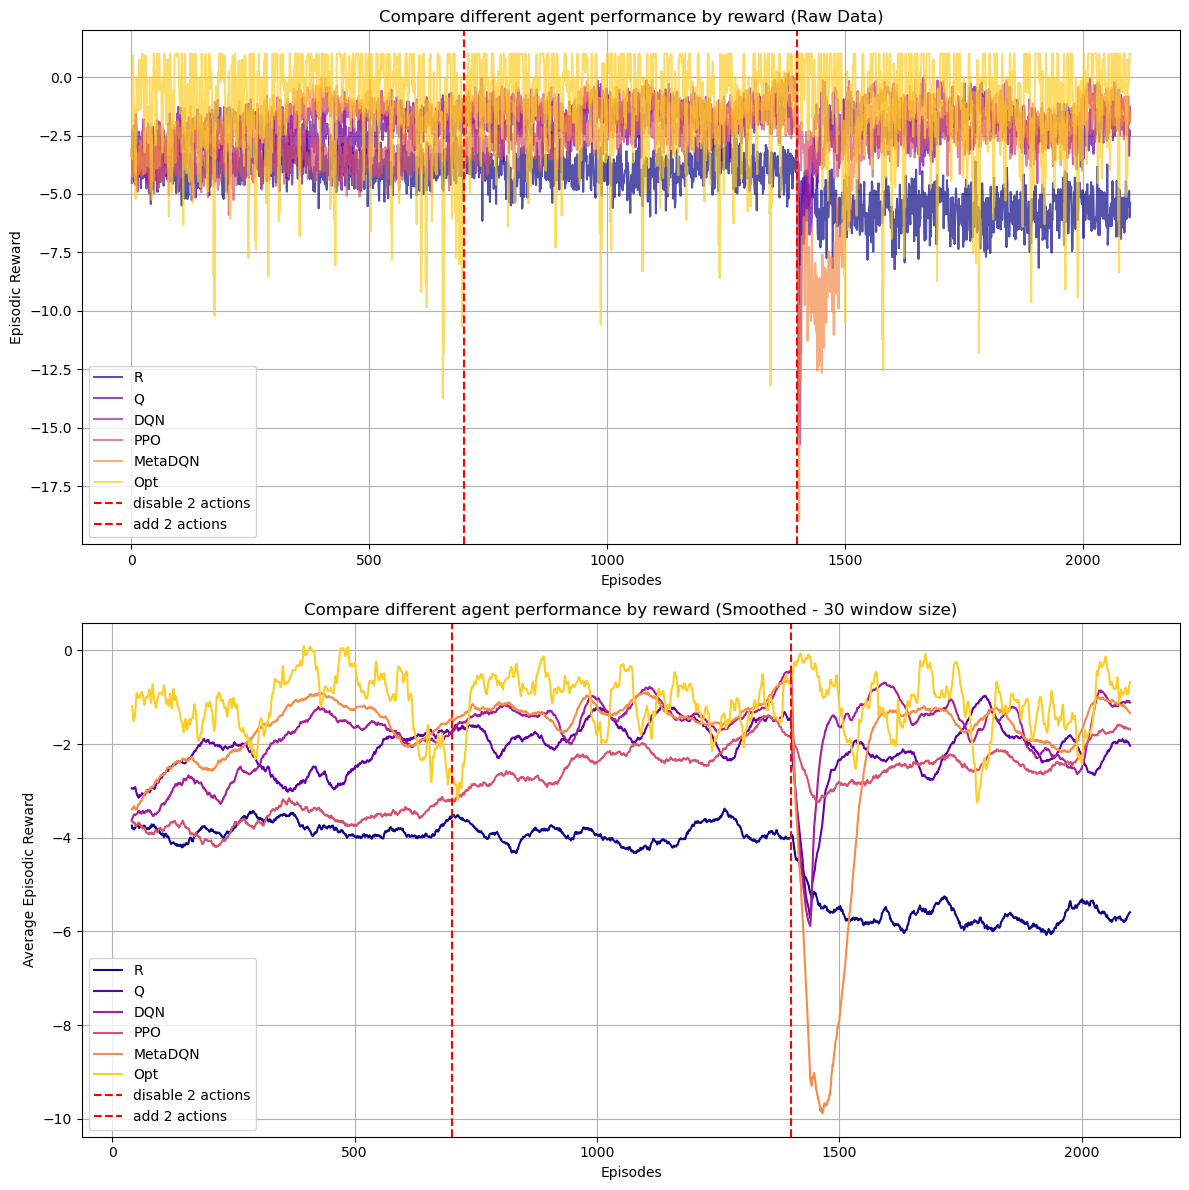

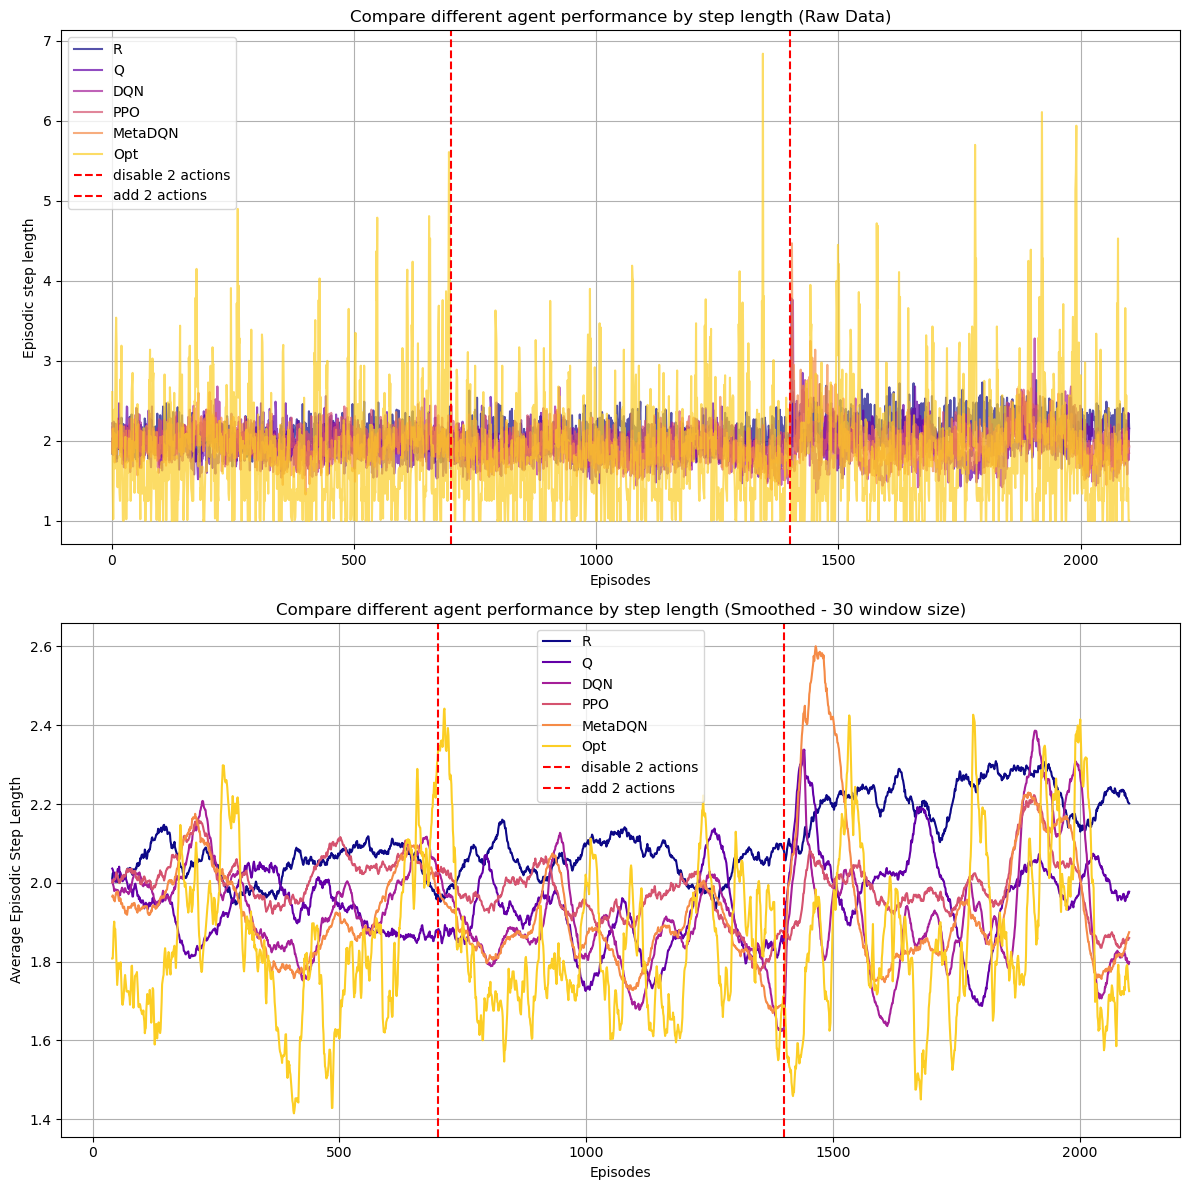

analysis for agent type: Q
Agent pre-drift average reward: -1.772
Optimal pre-drift average reward: -2.591
Recovery standard (90% of relative performance): 1.014
Recovered: False
Recovery not achieved in 651 windows
========== RECOVERY EVALUATION ==========
Agent pre-drift average reward: -1.772
Optimal pre-drift average reward: -2.591
Recovery standard (90% of relative performance): 1.006
Recovered: False
Recovery not achieved in 651 windows
========== RECOVERY EVALUATION ==========
analysis for agent type: DQN
Agent pre-drift average reward: -1.851
Optimal pre-drift average reward: -2.591
Recovery standard (90% of relative performance): 1.008
Recovered: False
Recovery not achieved in 651 windows
========== RECOVERY EVALUATION ==========
Agent pre-drift average reward: -1.851
Optimal pre-drift average reward: -2.591
Recovery standard (90% of relative performance): 1.000
Recovered: False
Recovery not achieved in 651 windows
========== RECOVERY EVALUATION ==========
analysis for agent t

In [8]:
test_all_agents()